In [1]:
import iris
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from cmcrameri import cm
from matplotlib.offsetbox import AnchoredText

In [2]:
from tqdm.notebook import tqdm

In [3]:
import iris.plot as iplt
import iris.quickplot as qplt

In [4]:
# My packages and local scripts
from aeolus.calc import spatial_mean, time_mean
from aeolus.const import add_planet_conf_to_cubes, init_const
from aeolus.coord import (
    coord_to_cube,
    get_cube_rel_days,
    get_xy_coords,
    isel,
    roll_cube_pm180,
)
from aeolus.core import AtmoSim
from aeolus.io import load_data, load_vert_lev, save_cubelist
from aeolus.model import um
from aeolus.plot import (
    add_custom_legend,
    fmt_lonlat,
    subplot_label_generator,
    tex2cf_units,
)
from aeolus.synthobs import (
    calc_stellar_flux,
    calc_transmission_spectrum,
    read_normalized_stellar_flux,
    read_spectral_bands,
)

In [5]:
from pouch.path import lsdir
from pouch.plot import (
    KW_AUX_TTL,
    KW_MAIN_TTL,
    KW_SBPLT_LABEL,
    KW_SYM0,
    figsave,
    linspace_pm1,
    use_style,
)

In [6]:
import mypaths
from commons import (
    DAYSIDE,
    GLM_MODEL_TIMESTEP,
    GLM_SUITE_ID,
    NIGHTSIDE,
    OPT_LABELS,
    SUITE_LABELS,
)

In [7]:
use_style()

# plt.style.use("dark_background")

bg_color = mpl.colors.to_rgb(plt.rcParams["figure.facecolor"])
fg_color = mpl.colors.to_rgb(plt.rcParams["text.color"])


Bad key legend.labelcolor in file /lustre/dirac/home/dc-serg1/sandbox/pouch/pouch/simple.mplstyle, line 15 ('legend.labelcolor : linecolor')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.3/matplotlibrc.template
or from the matplotlib source distribution


In [8]:
# SELECTED_SIM = {k: v for k, v in {**SIM}.items() if k in ["hab1", "hab2"]}
img_prefix = "ch111_synthobs"
# time_prof = ""
plotdir = mypaths.plotdir / "sa" / GLM_SUITE_ID / img_prefix

In [9]:
OPT_LABELS = {
    "hsw_llw": {
        "title": "MCICA; Spectral files: sp_sw_260_jm3, sp_lw_ga9",
        "kw_plt": {"color": "C0", "lw": 4},
    },
    "scaled_cloud": {
        "title": "Scaling factor; Spectral files: sp_sw_260_jm3, sp_lw_300_jm3",
        "kw_plt": {"color": "C1"},
    },
}

In [10]:
# # Load processed data
# runs = {}
# for suite_label, suite_prop in tqdm(SUITE_LABELS.items()):
#     top_label = f"{GLM_SUITE_ID}_synthobs_{suite_label}"
#     planet = suite_prop["planet"]
#     const = init_const(planet, directory=mypaths.constdir)
#     procdir = mypaths.sadir / top_label
#     break

runs = {}
for suite_label, suite_prop in SUITE_LABELS.items():
    for opt_label in OPT_LABELS.keys():
        sim_label = f"{suite_label}_{opt_label}"
        top_label = f"{GLM_SUITE_ID}_synthobs_{sim_label}"
        planet = suite_prop["planet"]
        const = init_const(planet, directory=mypaths.constdir)
        procdir = mypaths.sadir / top_label
        cl = load_data(procdir / "umglaa.ph000000")
        runs[sim_label] = AtmoSim(
            cl,
            name=sim_label,
            planet=planet,
            const_dir=mypaths.constdir,
            timestep=cl[0].attributes.get("timestep", GLM_MODEL_TIMESTEP),
            model=um,
            vert_coord=None,
        )
        runs[sim_label].theta_levels = iris.cube.Cube(
            data=load_vert_lev(mypaths.home / "vert" / "vertlevs_L38_29t_9s_50km"),
            units="m",
            long_name="level_height",
        )
        runs[sim_label].spectral_file_sw = (
            mypaths.home / "spectral" / "ga9_ref" / "sp_sw_260_jm3"
        )

In [11]:
VRBL_PLOT = {
    "trans_cloudy": {
        "cube": lambda AS: AS._cubes.extract_cube("m01s01i555"),
        "title": "All-sky",
        "tex_units": "$W$ $m^{-2}$",
        "kw_plt": {"linestyle": "-"},
    },
    "trans_clear": {
        "cube": lambda AS: AS._cubes.extract_cube("m01s01i556"),
        "title": "Clear-sky",
        "tex_units": "$W$ $m^{-2}$",
        "kw_plt": {"linestyle": "--", "dash_capstyle": "round"},
    },
}

In [12]:
RESULTS = {}
for suite_label in SUITE_LABELS.keys():
    for opt_label in OPT_LABELS.keys():
        sim_label = f"{suite_label}_{opt_label}"
        the_run = runs[sim_label]
        planet_top_of_atmosphere = the_run.const.radius + the_run.theta_levels[-1]
        stellar_constant_at_1_au = (
            the_run.const.solar_constant
            * (the_run.const.semi_major_axis / iris.cube.Cube(data=1, units="au")) ** 2
        )
        RESULTS[sim_label] = {}
        for (vrbl_key, vrbl_dict) in VRBL_PLOT.items():
            cube = vrbl_dict["cube"](the_run)
            cube.units = tex2cf_units(vrbl_dict["tex_units"])
            # cube.convert_units(tex2cf_units(vrbl_dict["tex_units"]))
            rp_eff_over_rs = calc_transmission_spectrum(
                cube,
                the_run.spectral_file_sw,
                stellar_constant_at_1_au,
                the_run.const.stellar_radius,
                planet_top_of_atmosphere,
                model=the_run.model,
            )
            RESULTS[sim_label][vrbl_key] = rp_eff_over_rs

/lustre/dirac/home/dc-serg1/mambaforge/envs/exo/lib/python3.9/site-packages/iris/cube.py:3909: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/lustre/dirac/home/dc-serg1/mambaforge/envs/exo/lib/python3.9/site-packages/iris/coords.py:1979: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'latitude'.
  warnings.warn(msg.format(self.name()))
/lustre/dirac/home/dc-serg1/mambaforge/envs/exo/lib/python3.9/site-packages/iris/coords.py:1979: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'longitude'.
  warnings.warn(msg.format(self.name()))
/lustre/dirac/home/dc-serg1/mambaforge/envs/exo/lib/python3.9/site-packages/iris/cube.py:3909: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/lustre/dirac/home/dc-serg1/mambaforge/envs/exo/lib/python3.9/site-packages/iris/coords.py:

Saved to ../../plots/sa/ch111/ch111_synthobs/ch111_synthobs__grcs_llcs__hsw_llw__trans_cloudy_trans_clear.png


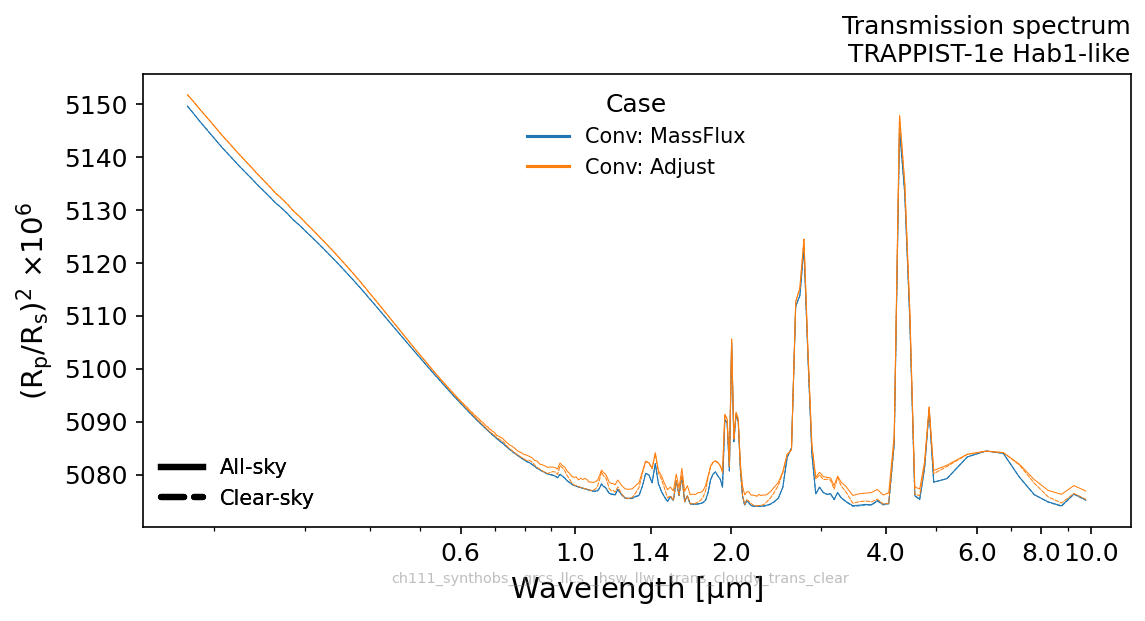

In [13]:
opt_label = "hsw_llw"
imgname = (
    f"{img_prefix}__{'_'.join(SUITE_LABELS.keys())}__"
    f"{opt_label}__{'_'.join(VRBL_PLOT.keys())}"
)
ncols = 1
nrows = 1
fig, axs = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(ncols * 8.5, nrows * 4), squeeze=False
)
# iletters = subplot_label_generator()
for ax in axs.flat:
    # ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
    ax.set_xlabel("Wavelength [$\mu$m]")
    ax.set_ylabel(r"($R_p/R_s)^2$ $\times 10^{6}$")
    ax.set_xscale("log")

    xticks = np.concatenate(
        [
            [0.6, 1, 1.4],
            np.arange(2, 12, 2),
            # np.arange(12, 22, 2),
        ]
    )
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    # ax.set_xlim(xticks.min(), xticks.max())

for (suite_label, suite_prop) in SUITE_LABELS.items():
    sim_label = f"{suite_label}_{opt_label}"
    for i, (vrbl_key, vrbl_dict) in enumerate(VRBL_PLOT.items()):
        # Calculate diagnostics
        cube = RESULTS[sim_label][vrbl_key] ** 2 * 1e6
        x = cube.coord("spectral_band_centres").points * 1e6
        ax.plot(
            x,
            cube.data,
            **suite_prop["kw_plt"],
            **vrbl_dict["kw_plt"],
            linewidth=0.5,
            # marker="o",
            # ms=3,
        )

ax.set_title(
    "Transmission spectrum\nTRAPPIST-1e Hab1-like",
    loc="right",
    size="medium",
)

add_custom_legend(
    ax,
    {v["title"]: {"linestyle": "-", **v["kw_plt"]} for v in SUITE_LABELS.values()},
    loc="upper center",
    # bbox_to_anchor=(0.5, 1.05),
    frameon=False,
    ncol=1,
    title="Case",
    fontsize="small",
)
add_custom_legend(
    ax,
    {
        v["title"]: {"color": "k", "linewidth": 3, **v["kw_plt"]}
        for v in VRBL_PLOT.values()
    },
    loc="lower left",
    frameon=False,
    ncol=1,
    fontsize="small",
)


figsave(fig, plotdir / imgname)

Saved to ../../plots/sa/ch111/ch111_synthobs/ch111_synthobs__grcs_llcs__hsw_llw_scaled_cloud__trans_cloudy_trans_clear.png


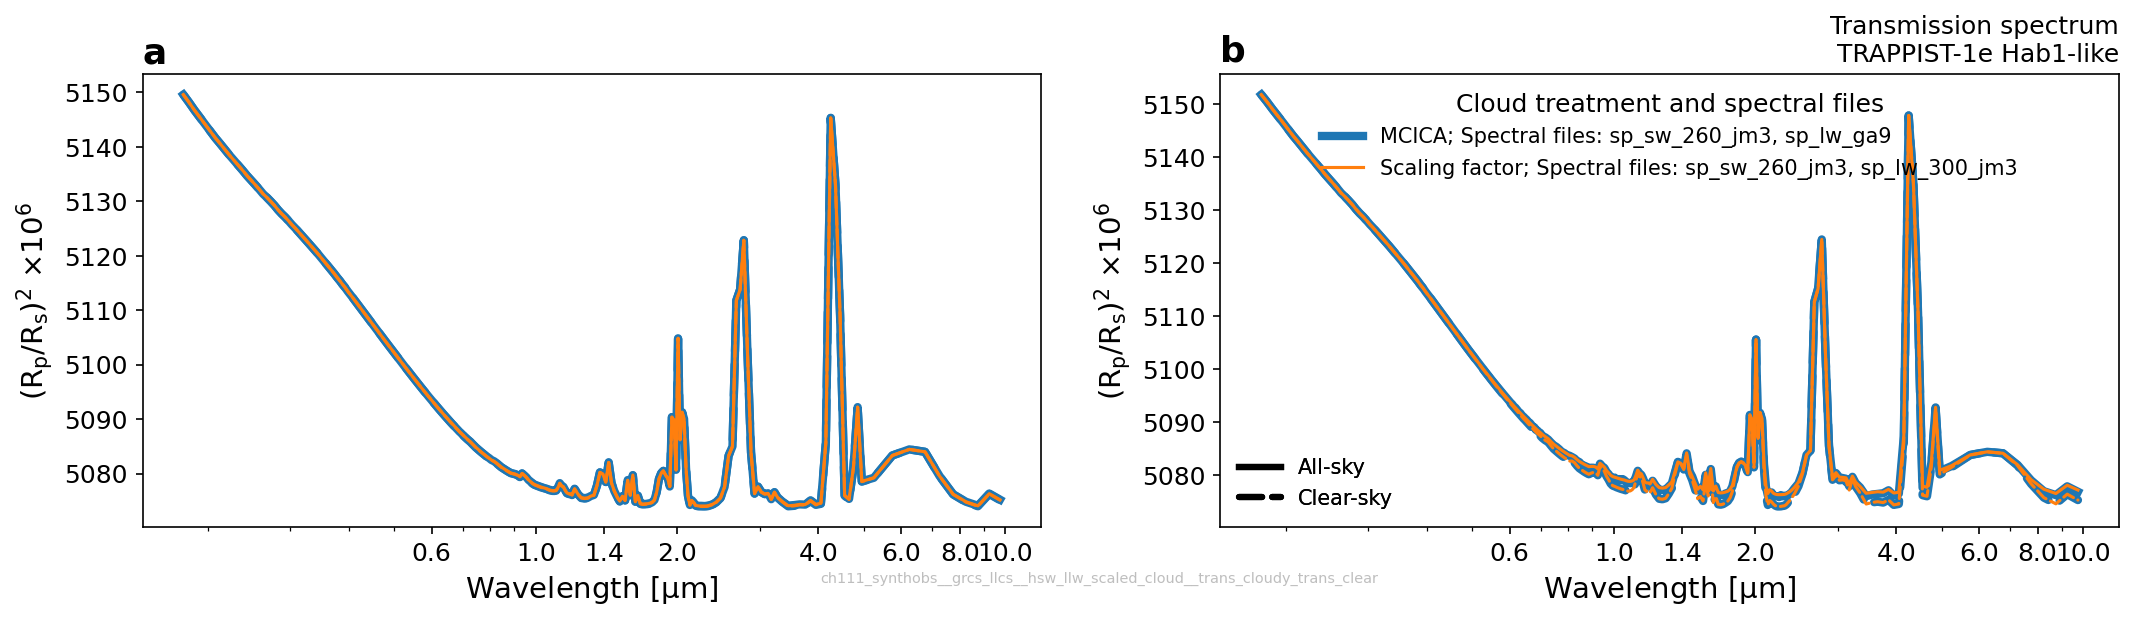

In [14]:
imgname = (
    f"{img_prefix}__{'_'.join(SUITE_LABELS.keys())}__"
    f"{'_'.join(OPT_LABELS.keys())}__{'_'.join(VRBL_PLOT.keys())}"
)
ncols = 2
nrows = 1
fig, axs = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(ncols * 8.5, nrows * 4), squeeze=False
)
iletters = subplot_label_generator()
for ax in axs.flat:
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
    ax.set_xlabel("Wavelength [$\mu$m]")
    ax.set_ylabel(r"($R_p/R_s)^2$ $\times 10^{6}$")
    ax.set_xscale("log")

    xticks = np.concatenate(
        [
            [0.6, 1, 1.4],
            np.arange(2, 12, 2),
            # np.arange(12, 22, 2),
        ]
    )
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    # ax.set_xlim(xticks.min(), xticks.max())

for suite_label, ax in zip(SUITE_LABELS.keys(), axs.flat):
    for opt_label, opt_prop in OPT_LABELS.items():
        sim_label = f"{suite_label}_{opt_label}"
        for i, (vrbl_key, vrbl_dict) in enumerate(VRBL_PLOT.items()):
            # Calculate diagnostics
            cube = RESULTS[sim_label][vrbl_key] ** 2 * 1e6
            x = cube.coord("spectral_band_centres").points * 1e6
            ax.plot(
                x,
                cube.data,
                **opt_prop["kw_plt"],
                **vrbl_dict["kw_plt"],
                # marker="o",
                # ms=3,
            )

ax.set_title(
    "Transmission spectrum\nTRAPPIST-1e Hab1-like",
    loc="right",
    size="medium",
)

add_custom_legend(
    ax,
    {v["title"]: {"linestyle": "-", **v["kw_plt"]} for v in OPT_LABELS.values()},
    loc="upper center",
    # bbox_to_anchor=(0.5, 1.05),
    frameon=False,
    ncol=1,
    title="Cloud treatment and spectral files",
    fontsize="small",
)
add_custom_legend(
    ax,
    {
        v["title"]: {"color": "k", "linewidth": 3, **v["kw_plt"]}
        for v in VRBL_PLOT.values()
    },
    loc="lower left",
    frameon=False,
    ncol=1,
    fontsize="small",
)


figsave(fig, plotdir / imgname)

Saved to ../../plots/sa/ch111/ch111_synthobs/ch111_synthobs__grcs_llcs__hsw_llw_scaled_cloud__trans_cloudy_trans_clear__diffs.png


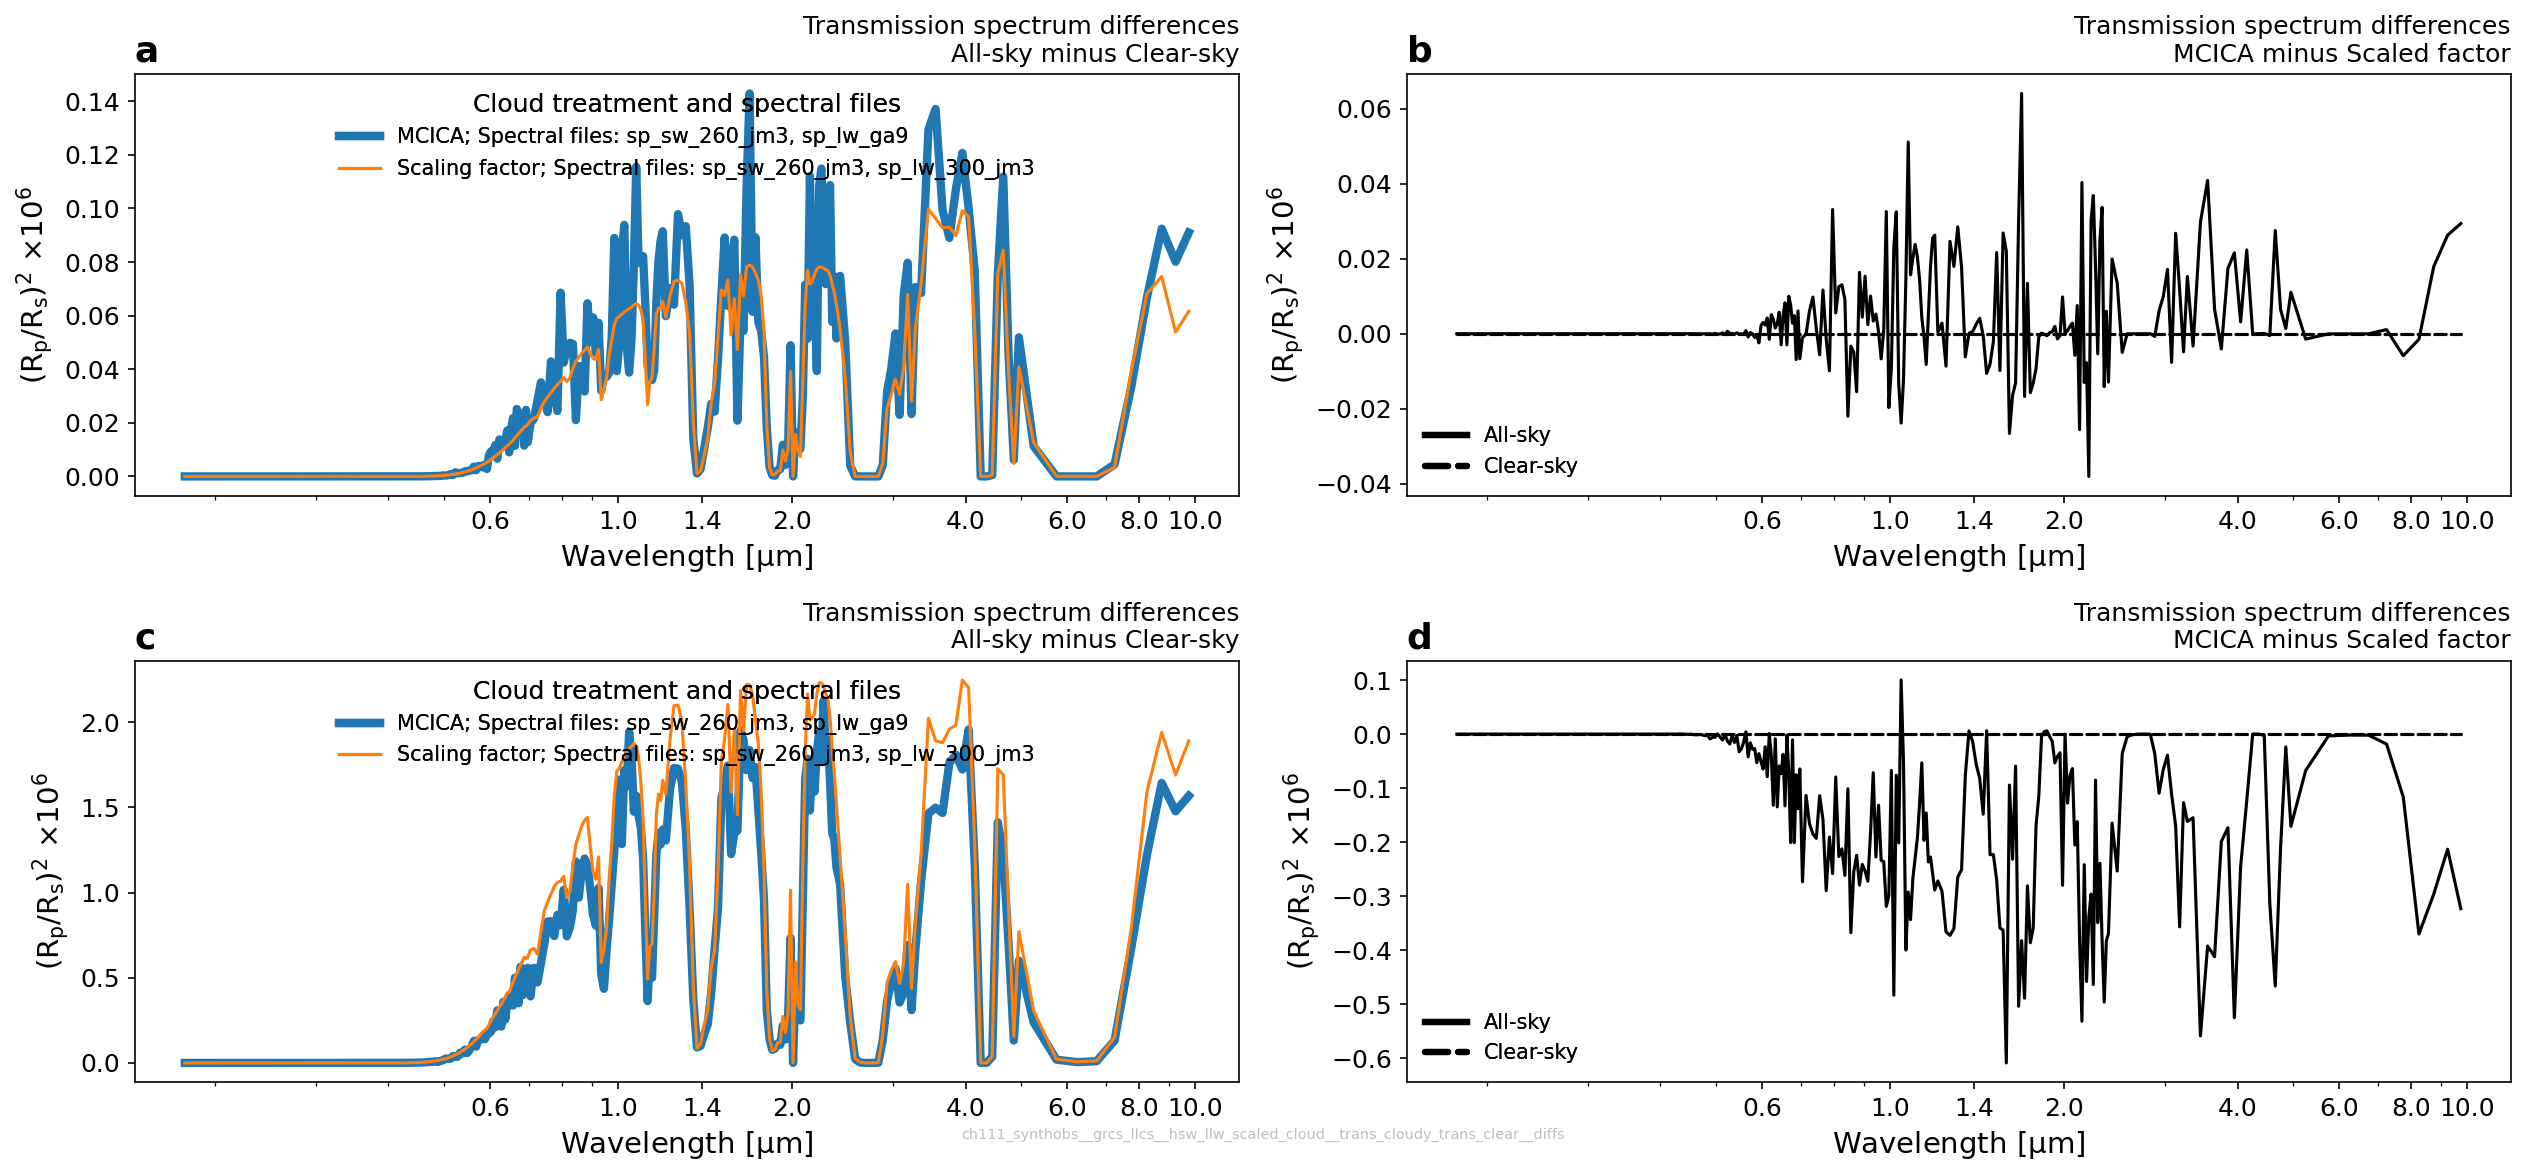

In [15]:
imgname = (
    f"{img_prefix}__{'_'.join(SUITE_LABELS.keys())}__"
    f"{'_'.join(OPT_LABELS.keys())}__{'_'.join(VRBL_PLOT.keys())}__diffs"
)
ncols = 2
nrows = len(SUITE_LABELS)
fig, axs = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(ncols * 8.5, nrows * 4), squeeze=False
)
iletters = subplot_label_generator()
for ax in axs.flat:
    ax.set_title(f"{next(iletters)}", **KW_SBPLT_LABEL)
    ax.set_xlabel("Wavelength [$\mu$m]")
    ax.set_ylabel(r"($R_p/R_s)^2$ $\times 10^{6}$")
    ax.set_xscale("log")
    xticks = np.concatenate(
        [
            [0.6, 1, 1.4],
            np.arange(2, 12, 2),
            # np.arange(12, 22, 2),
        ]
    )
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks)
    # ax.set_xlim(xticks.min(), xticks.max())

for suite_label, axrow in zip(SUITE_LABELS.keys(), axs):
    ax = axrow[0]
    ax.set_title(
        "Transmission spectrum differences\nAll-sky minus Clear-sky",
        loc="right",
        size="medium",
    )
    for opt_label, opt_prop in OPT_LABELS.items():
        sim_label = f"{suite_label}_{opt_label}"
        cube = (
            RESULTS[sim_label]["trans_cloudy"] ** 2
            - RESULTS[sim_label]["trans_clear"] ** 2
        ) * 1e6
        x = cube.coord("spectral_band_centres").points * 1e6
        ax.plot(
            x,
            cube.data,
            **opt_prop["kw_plt"],
        )
    add_custom_legend(
        ax,
        {v["title"]: {"linestyle": "-", **v["kw_plt"]} for v in OPT_LABELS.values()},
        loc="upper center",
        # bbox_to_anchor=(0.5, 1.05),
        frameon=False,
        ncol=1,
        title="Cloud treatment and spectral files",
        fontsize="small",
    )

    ax = axrow[1]
    ax.set_title(
        "Transmission spectrum differences\nMCICA minus Scaled factor",
        loc="right",
        size="medium",
    )
    for i, (vrbl_key, vrbl_dict) in enumerate(VRBL_PLOT.items()):
        cube = (
            RESULTS[f"{suite_label}_hsw_llw"][vrbl_key] ** 2
            - RESULTS[f"{suite_label}_scaled_cloud"][vrbl_key] ** 2
        ) * 1e6
        x = cube.coord("spectral_band_centres").points * 1e6
        ax.plot(
            x,
            cube.data,
            color="k",
            **vrbl_dict["kw_plt"],
            # marker="o",
            # ms=3,
        )
    add_custom_legend(
        ax,
        {
            v["title"]: {"color": "k", "linewidth": 3, **v["kw_plt"]}
            for v in VRBL_PLOT.values()
        },
        loc="lower left",
        frameon=False,
        ncol=1,
        fontsize="small",
    )

fig.tight_layout()
figsave(fig, plotdir / imgname)

In [16]:
normalized_stellar_flux = read_normalized_stellar_flux(the_run.spectral_file_sw)

Text(0.0, 1.0, 'Spectral file: ga9_ref/sp_sw_260_jm3')

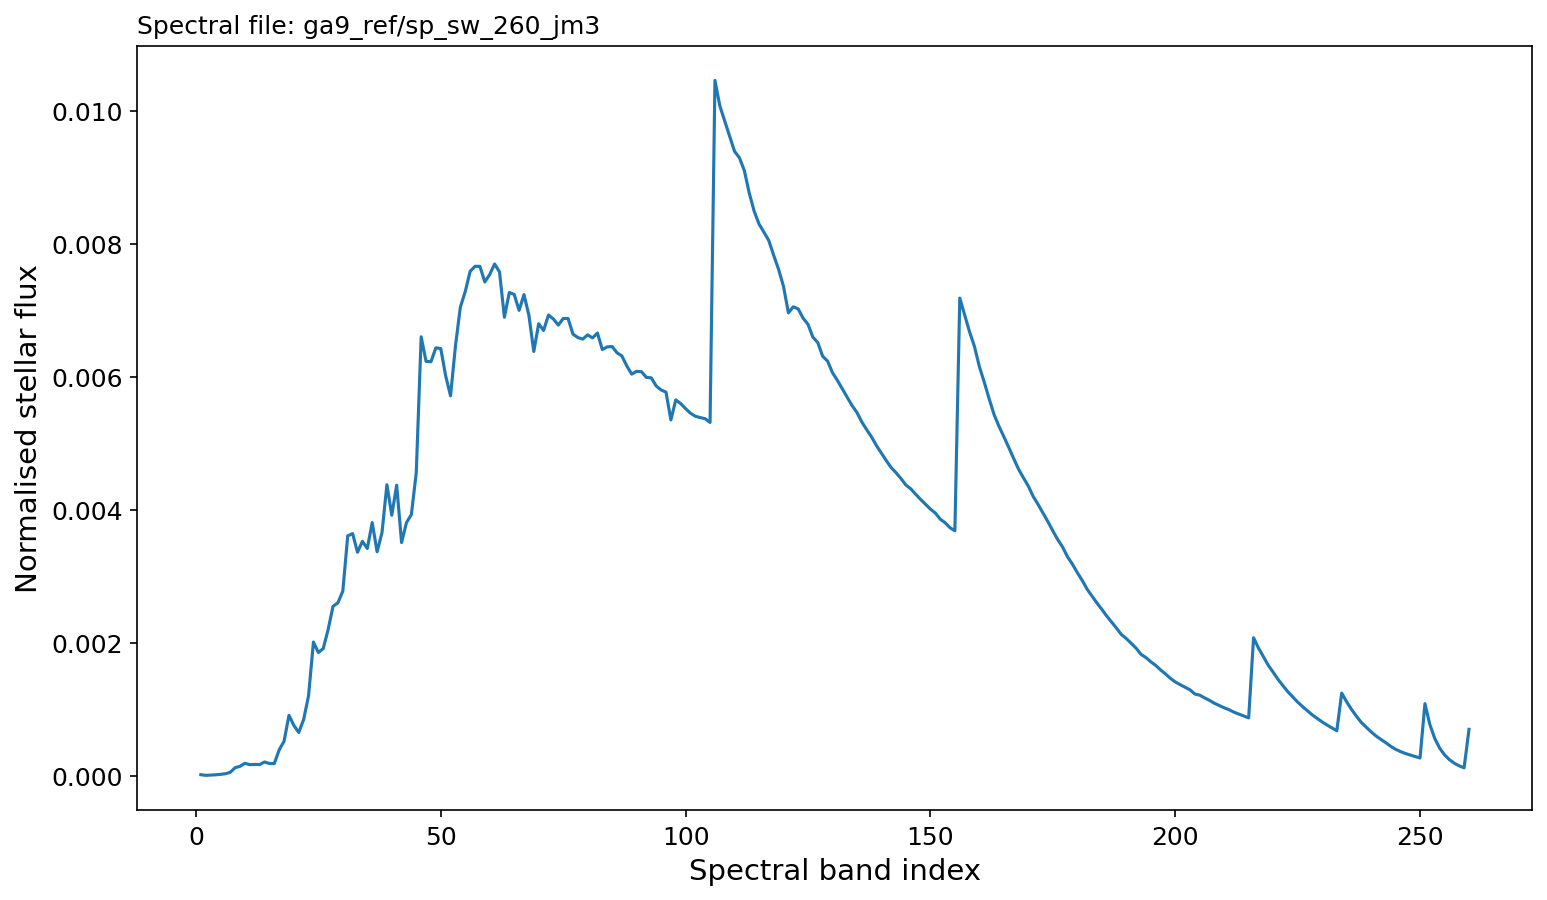

In [17]:
fig, ax = plt.subplots()
ax.plot(
    normalized_stellar_flux.coord("spectral_band_index").points,
    normalized_stellar_flux.data,
)
ax.set_xlabel("Spectral band index")
ax.set_ylabel("Normalised stellar flux")
ax.set_title(f"Spectral file: ga9_ref/{the_run.spectral_file_sw.name}", loc="left", size="medium")

# figsave(fig, plotdir / f"{spectral_file.name}__normalised_stellar_flux")

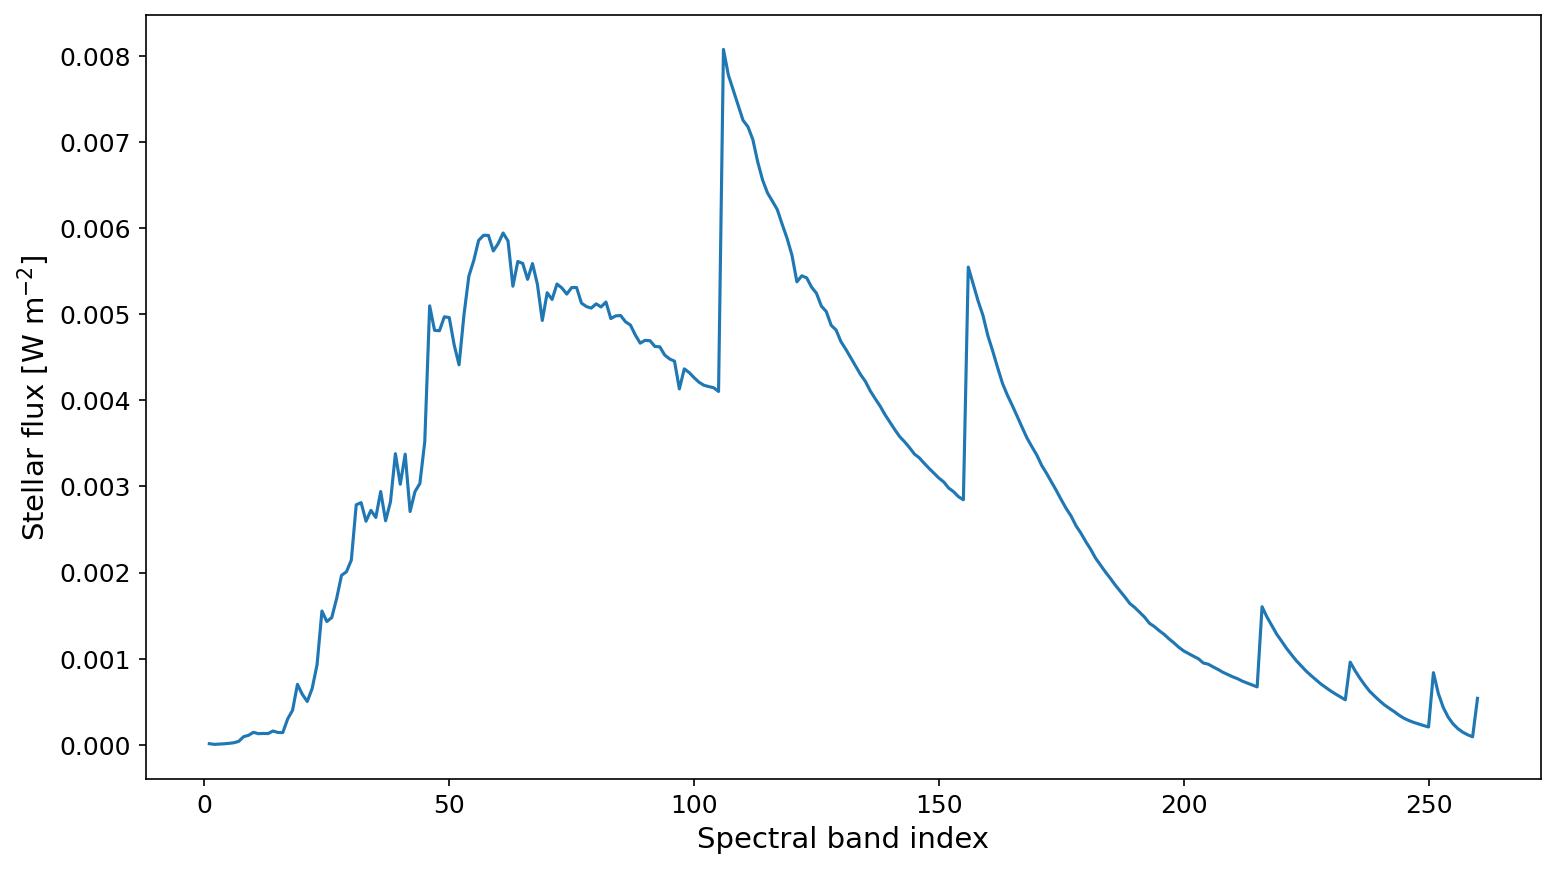

In [18]:
stellar_flux = calc_stellar_flux(the_run.spectral_file_sw, stellar_constant_at_1_au)

fig, ax = plt.subplots()
ax.plot(stellar_flux.coord("spectral_band_index").points, stellar_flux.data)
ax.set_xlabel("Spectral band index")
ax.set_ylabel("Stellar flux [W $m^{-2}$]");